# Business and data understanding

## Purpose
This notebook contains the business and data understading phase for the Kaggle's competition [San Francisco Crime Classification](https://www.kaggle.com/competitions/sf-crime/).

## Methodology
- Simple data description;
- Data description using pandas-profiling.

## Results
*Working in progress*.

## TODOs:
- [ ] todo 1.

# Setup

## Library import

In [1]:
import os
from pathlib import Path

import folium
import humps
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import plotly
import plotly.express as px
import plotly.graph_objs as go
import plotly.offline as ply

# TODO: Testing pregex lib.
from pregex.core.classes import AnyLetter, AnyDigit, AnyFrom
from pregex.core.quantifiers import Optional, AtLeastAtMost
from pregex.core.operators import Either
from pregex.core.groups import Capture
from pregex.core.pre import Pregex

# Autoreload extension
if 'autoreload' not in get_ipython().extension_manager.loaded:
    %load_ext autoreload
    
%autoreload 2

# Options for pandas and plotly
pd.options.display.max_columns = None
pd.options.display.max_rows = 100
pd.options.display.max_colwidth = 200
plotly.offline.init_notebook_mode(connected=True)

## Local library import

In [2]:
if Path.cwd().name == 'notebooks':
    os.chdir('../')

from src.utils.data_describe import serie_nulos, cardinalidade

if Path.cwd().name == 'sf_crime':
    os.chdir('./notebooks/')

## Parameter definition
We set all relevant parameters for our notebook. By convention, parameters are uppercase, while all the 
other variables follow Python's guidelines.

In [3]:
RAW_DATA = '../data/raw/' 
EXTERNAL_DATA = '../data/external/' 
INTERIM_DATA = '../data/interim/' 
PROCESSED_DATA = '../data/processed/'
REFERENCES = '../references/'
RANDOM_STATE = 42

## Data import
We retrieve all the required data for the analysis.

In [4]:
try:
    df = pd.read_parquet(EXTERNAL_DATA + 'train.pqt')
    print('Parquet file loaded.')

except FileNotFoundError as e:
    df = pd.read_csv(
        EXTERNAL_DATA + 'train.csv',
        parse_dates=['Dates'],
        dtype={'X': float, 'Y': float}
    )
    df.to_parquet(EXTERNAL_DATA + 'train.pqt', index=False)
    print('CSV file loaded and parquet created.')

print(f'Dataset size: {df.shape}')

df.tail(3)

Parquet file loaded.
Dataset size: (878049, 9)


,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
878046,2003-01-06 00:01:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Monday,SOUTHERN,NONE,5TH ST / FOLSOM ST,-122.403390,37.780266
878047,2003-01-06 00:01:00,VANDALISM,"MALICIOUS MISCHIEF, VANDALISM OF VEHICLES",Monday,SOUTHERN,NONE,TOWNSEND ST / 2ND ST,-122.390531,37.780607
878048,2003-01-06 00:01:00,FORGERY/COUNTERFEITING,"CHECKS, FORGERY (FELONY)",Monday,BAYVIEW,NONE,1800 Block of NEWCOMB AV,-122.394926,37.738212


# Data evaluation
What are each attribute and how do they behave.

## Null values

In [5]:
df_evaluation = df.copy()

df_evaluation.columns = [humps.decamelize(x.strip()).lower() for x in df_evaluation.columns.tolist()]

df_evaluation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878049 entries, 0 to 878048
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   dates        878049 non-null  datetime64[ns]
 1   category     878049 non-null  object        
 2   descript     878049 non-null  object        
 3   day_of_week  878049 non-null  object        
 4   pd_district  878049 non-null  object        
 5   resolution   878049 non-null  object        
 6   address      878049 non-null  object        
 7   x            878049 non-null  float64       
 8   y            878049 non-null  float64       
dtypes: datetime64[ns](1), float64(2), object(6)
memory usage: 60.3+ MB


## Cardinality

In [6]:
cardinalidade(df_evaluation)

,Atributo,DType,Cardinalidade,Valores,Proporção Nulos
3,day_of_week,object,7,"[Friday, Monday, Saturday, Sunday, Thursday, Tuesday, Wednesday]",0.0
4,pd_district,object,10,"[BAYVIEW, CENTRAL, INGLESIDE, MISSION, NORTHERN, PARK, RICHMOND, SOUTHERN, TARAVAL, TENDERLOIN]",0.0
5,resolution,object,17,"[ARREST, BOOKED, ARREST, CITED, CLEARED-CONTACT JUVENILE FOR MORE INFO, COMPLAINANT REFUSES TO PROSECUTE, DISTRICT ATTORNEY REFUSES TO PROSECUTE, EXCEPTIONAL CLEARANCE, JUVENILE ADMONISHED, JUVENI...",0.0
1,category,object,39,"[ARSON, ASSAULT, BAD CHECKS, BRIBERY, BURGLARY, DISORDERLY CONDUCT, DRIVING UNDER THE INFLUENCE, DRUG/NARCOTIC, DRUNKENNESS, EMBEZZLEMENT, EXTORTION, FAMILY OFFENSES, FORGERY/COUNTERFEITING, FRAUD...",0.0
2,descript,object,879,"[ABANDONMENT OF CHILD, ABORTION, ACCESS CARD INFORMATION, PUBLICATION OF, ACCESS CARD INFORMATION, THEFT OF, ACCIDENTAL BURNS, ACCIDENTAL SHOOTING, ACTS AGAINST PUBLIC TRANSIT, ADVERTISING DISTRIB...",0.0
6,address,object,23228,"[0 Block of HARRISON ST, 0 Block of 10TH AV, 0 Block of 10TH ST, 0 Block of 11TH ST, 0 Block of 12TH AV, 0 Block of 12TH ST, 0 Block of 13TH ST, 0 Block of 14TH AV, 0 Block of 14TH ST, 0 Block of...",0.0
0,dates,datetime64[ns],389257,"[2003-01-06T00:01:00.000000000, 2003-01-06T00:15:00.000000000, 2003-01-06T00:20:00.000000000, 2003-01-06T00:31:00.000000000, 2003-01-06T00:33:00.000000000, 2003-01-06T00:40:00.000000000, 2003-01-0...",0.0


## Attribute: 'dates'

The 'Dates' attributes has information about date and time of the event. I will split it, therefore, it will be possible to analyze trends through the day and within a day.

In [7]:
if 'dates' in df_evaluation.columns:
    df_evaluation['dates_year'] = df_evaluation['dates'].dt.year
    df_evaluation['dates_month'] = df_evaluation['dates'].dt.month
    df_evaluation['dates_hour'] = df_evaluation['dates'].dt.time
    df_evaluation['dates_day'] = df_evaluation['dates'].dt.date
    df_evaluation = df_evaluation[[
        'dates_year', 'dates_month', 'dates_day', 'dates_hour', 'day_of_week',
        'category', 'descript', 'pd_district', 'resolution', 'address', 'x', 'y'
    ]]
else:
    pass

df_evaluation.head()

,dates_year,dates_month,dates_day,dates_hour,day_of_week,category,descript,pd_district,resolution,address,x,y
0,2015,5,2015-05-13,23:53:00,Wednesday,WARRANTS,WARRANT ARREST,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
1,2015,5,2015-05-13,23:53:00,Wednesday,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
2,2015,5,2015-05-13,23:33:00,Wednesday,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414
3,2015,5,2015-05-13,23:30:00,Wednesday,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873
4,2015,5,2015-05-13,23:30:00,Wednesday,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541


### Period of the occurences

In [8]:
df_temp = df_evaluation.groupby(by=['dates_year']).agg({'dates_day': 'nunique', 'descript': 'count', 'category': pd.Series.mode}).rename(
    columns={'dates_day': 'days_with_occurences', 'descript': 'qty_occurences', 'category': 'most_frequent'}).reset_index()

# df_date_agg['occurences_per_day'] #TODO: Verify the mean number of occurences per day.

df_temp

,dates_year,days_with_occurences,qty_occurences,most_frequent
0,2003,182,73902,LARCENY/THEFT
1,2004,182,73422,LARCENY/THEFT
2,2005,181,70779,LARCENY/THEFT
3,2006,183,69909,LARCENY/THEFT
4,2007,182,68015,LARCENY/THEFT
5,2008,182,70174,LARCENY/THEFT
6,2009,181,69000,LARCENY/THEFT
7,2010,180,66542,LARCENY/THEFT
8,2011,183,66619,LARCENY/THEFT
9,2012,183,71731,LARCENY/THEFT


## Attribute: 'x' and 'y' (or longitude and latitude)

In [9]:
# Describing the 'x' and 'y' attributes:
df_evaluation[['x', 'y']].describe().T

,count,mean,std,min,25%,50%,75%,max
x,878049.0,-122.422616,0.030354,-122.513642,-122.432952,-122.416420,-122.406959,-120.5
y,878049.0,37.771020,0.456893,37.707879,37.752427,37.775421,37.784369,90.0


In [10]:
#Looking for a visual pattern in the registries with IMPOSSIBLE coordinates.
df_temp = df_evaluation.loc[(df_evaluation['x']>=-120.5) | (df_evaluation['y']>=90), :]

print(f'Registries with IMPOSSIBLE COORDINATES: {len(df_temp)}')

df_temp.groupby(by=['dates_year', 'pd_district', 'resolution', 'category']).agg({'dates_month': 'count'}).head(15)

Registries with IMPOSSIBLE COORDINATES: 67


dates_month
dates_year pd_district resolution                       category                          
2003       BAYVIEW     COMPLAINANT REFUSES TO PROSECUTE ROBBERY                          1
                       NONE                             LARCENY/THEFT                    1
           INGLESIDE   ARREST, CITED                    OTHER OFFENSES                   2
           NORTHERN    ARREST, BOOKED                   STOLEN PROPERTY                  1
                                                        WARRANTS                         2
                       NONE                             LARCENY/THEFT                    1
           RICHMOND    NONE                             VEHICLE THEFT                    2
           SOUTHERN    ARREST, BOOKED                   WARRANTS                         1
                       COMPLAINANT REFUSES TO PROSECUTE SEX OFFENSES FORCIBLE            1
                       NONE                             LARCENY/THEFT                    2
2004       BAYVIEW     ARREST, CITED                    OTHER OFFENSES                   1
                       NONE                             SUSPICIOUS OCC                   1
           CENTRAL     NONE                             LARCENY/THEFT                    1
           INGLESIDE   JUVENILE BOOKED                  ASSAULT                          1
           MISSION     ARREST, CITED                    OTHER OFFENSES                   1

**Attention!**

As it can be seen above, there is a pair of coordinates that DO NOT makes sense: (-120.5, 90.0). They appeared only in 2003, 2004 and 2005, and it does not seem to follow a pattern.

**Action:**

- At this moment, the action that will be taken is to use the mean for the set of 'dates_year', 'pd_district', 'resolution', 'category'.
- Another possibility is use the similarity among the address text and use the respectively coordinate.

### Transforming the coordinates outside SF area

In [11]:
df_evaluation['x'] = np.where((df_evaluation['x']>=-120.5), np.nan, df_evaluation['x'])
df_evaluation['y'] = np.where((df_evaluation['y']>=90), np.nan, df_evaluation['y'])

#TODO: Use the mean of each categories 'dates_year', 'pd_district', 'resolution', 'category' as the imputed number.
df_temp = df_evaluation.groupby(by=['pd_district']).agg({'x': 'mean', 'y': 'mean'}).reset_index()

lst_year = df_evaluation.loc[(df_evaluation['x'].isna()) & (df_evaluation['y'].isna()), 'dates_year'].unique().tolist()
lst_district = df_evaluation.loc[(df_evaluation['x'].isna()) & (df_evaluation['y'].isna()), 'pd_district'].unique().tolist()

for district in lst_district:
    # Inputing mean values in 'x'
    df_evaluation.loc[
        (df_evaluation['pd_district']==district) & (df_evaluation['x'].isna()),
        'x'] = df_temp.loc[df_temp['pd_district']==district, 'x'].mean()
    
    df_evaluation.loc[
        (df_evaluation['pd_district']==district)  & (df_evaluation['y'].isna()),
        'y'] = df_temp.loc[df_temp['pd_district']==district, 'y'].mean()

df_evaluation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878049 entries, 0 to 878048
Data columns (total 12 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   dates_year   878049 non-null  int64  
 1   dates_month  878049 non-null  int64  
 2   dates_day    878049 non-null  object 
 3   dates_hour   878049 non-null  object 
 4   day_of_week  878049 non-null  object 
 5   category     878049 non-null  object 
 6   descript     878049 non-null  object 
 7   pd_district  878049 non-null  object 
 8   resolution   878049 non-null  object 
 9   address      878049 non-null  object 
 10  x            878049 non-null  float64
 11  y            878049 non-null  float64
dtypes: float64(2), int64(2), object(8)
memory usage: 80.4+ MB


## Target: 'category'

'category' is our target and is related to 'descript'. Moreover, the attributes 'descript' and 'resolution' are present only in train dataset, therefore, they will be not used for train the model. 

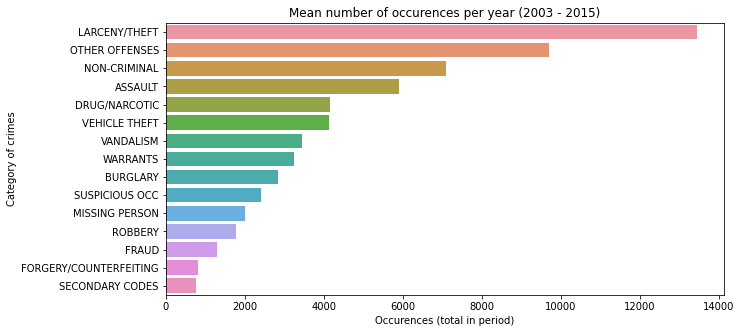

In [12]:
# Creating dataframe that will be used to produce the graph.
df_graph = df_evaluation.groupby(by=['category', 'dates_year']).agg({'address': 'count'}).rename(
    columns={'address': 'count'}).reset_index()
df_graph = df_graph.groupby(by=['category']).agg({'count': 'mean'}).reset_index()
df_graph.sort_values(by=['count'], inplace=True, ascending=False)

# Graph
fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(data=df_graph[:15], y='category', x='count', ax=ax)
ax.set(
    xlabel='Occurences (total in period)', ylabel='Category of crimes',
    title=f"Mean number of occurences per year ({df_evaluation['dates_year'].min()} - {df_evaluation['dates_year'].max()})"
);

## Attribute: pd_district

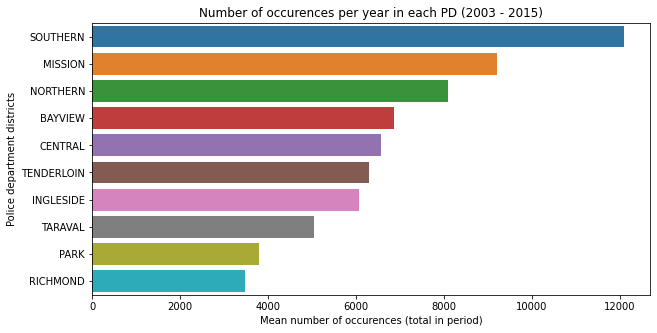

In [13]:
# Creating dataframe that will be used to produce the graph.
df_graph = df_evaluation.groupby(by=['pd_district', 'dates_year']).agg({'address': 'count'}).rename(
    columns={'address': 'count'}).reset_index()
df_graph = df_graph.groupby(by=['pd_district']).agg({'count': 'mean'}).reset_index()
df_graph.sort_values(by=['count'], inplace=True, ascending=False)

# Graph
fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(data=df_graph, y='pd_district', x='count', ax=ax)
ax.set(
    xlabel='Mean number of occurences (total in period)', ylabel='Police department districts',
    title=f"Number of occurences per year in each PD ({df_evaluation['dates_year'].min()} - {df_evaluation['dates_year'].max()})"
);

## Attribute: address

In 'address', we can see that it has a very large cardinality (23228 distinct occurences), and the largest proportion is only 3%. Here, one option can be extracting just the main street name.  name of the street, i.e., to exclude the number of the block.

I found two patterns in the 'Address' atribute:

1. Registries specifying the block of the street, and
1. Registries with two streets separated with a '/'.

In the first case, I will get just the street's name. And, in the second one, I will get just the firsthalf of the name (part before '/').

### Comments:
With this strategy, the number of distinct values decreased to 2031 values (~9% of the original).

In [14]:
df_graph = pd.DataFrame(100 * df_evaluation['address'].value_counts() / df_evaluation['address'].value_counts().sum()).reset_index()
df_graph.columns = ['address', 'proportion']
df_graph

,address,proportion
0,800 Block of BRYANT ST,3.021813
1,800 Block of MARKET ST,0.749503
2,2000 Block of MISSION ST,0.580492
3,1000 Block of POTRERO AV,0.462730
4,900 Block of MARKET ST,0.370253
...,...,...
23223,PRECITA AV / CESAR CHAVEZ ST,0.000114
23224,0 Block of COLUSA PL,0.000114
23225,2800 Block of KEITH ST,0.000114
23226,CABRILLO ST / ARGUELLO BL,0.000114


In [15]:
def address_split(word):
    if ' of ' in word:
        return word.lower().partition('block of ')[2].lower().strip()
    elif ' / ' in word:
        return word.partition(' / ')[0].lower().strip()
    else:
        return np.nan

In [16]:
df_graph['simplified_address'] = df_graph['address'].apply(address_split)
df_temp = df_graph.groupby(by=['simplified_address']).agg({'proportion': 'sum'}).reset_index()
df_temp.sort_values(by='proportion', ascending=False, inplace=True)
df_temp

,simplified_address,proportion
1258,mission st,4.184732
1185,market st,3.997157
303,bryant st,3.417007
1872,turk st,1.774161
621,eddy st,1.498208
...,...,...
255,blanche st,0.000114
111,alta mar wy,0.000114
902,hobart al,0.000114
1319,nellie st,0.000114


## Map

### How the crimes are distributed over a map?

In [17]:
df_evaluation[['x', 'y']].describe().T

,count,mean,std,min,25%,50%,75%,max
x,878049.0,-122.422763,0.025285,-122.513642,-122.432952,-122.416420,-122.406959,-122.364937
y,878049.0,37.767035,0.024164,37.707879,37.752427,37.775421,37.784368,37.819975


In [18]:
df_map = df_evaluation.loc[
    (df_evaluation['x'] > round(df_evaluation['x'].quantile(.01), 1))
    & (df_evaluation['x'] < round(df_evaluation['x'].quantile(.99), 1))
    & (df_evaluation['y'] > round(df_evaluation['y'].quantile(.01), 1))
    & (df_evaluation['y'] < round(df_evaluation['y'].quantile(.99), 1))
]

print(f"""df_evaluation: {len(df_evaluation)} registries
df_map: {len(df_map)} registries

{round(100 * ((len(df_evaluation) - len(df_map))/len(df_evaluation)), 1)}% of the registries are beyond the 1% and 99% percentils.""")

df_evaluation: 878049 registries
df_map: 729067 registries

17.0% of the registries are beyond the 1% and 99% percentils.


#### Using Map

In [29]:
df_temp = df_evaluation.groupby(by=['pd_district', 'category', 'dates_year']).agg(
    {'dates_day': 'count', 'x': 'mean', 'y': 'mean'}).rename(columns={'dates_day': 'count'}).reset_index()
df_temp.sort_values(by=['count'], ascending=False, inplace=True)

df_temp_agg = df_temp.groupby(by=['category']).agg({'count': 'sum'}).reset_index()
lst_most_frq_crimes = df_temp_agg.sort_values(by=['count'], ascending=False)['category'].values.tolist()[:6]

last_year = df_temp['dates_year'].max()
df_temp = df_temp.loc[(df_temp['dates_year']==last_year) & (df_temp['category'].isin(lst_most_frq_crimes))]
df_temp.head()

,pd_district,category,dates_year,count,x,y
3367,SOUTHERN,LARCENY/THEFT,2015,1927,-122.402972,37.780740
2061,NORTHERN,LARCENY/THEFT,2015,1370,-122.428202,37.788126
674,CENTRAL,LARCENY/THEFT,2015,1196,-122.408930,37.797146
3419,SOUTHERN,NON-CRIMINAL,2015,599,-122.405180,37.780178
3432,SOUTHERN,OTHER OFFENSES,2015,576,-122.404369,37.779960


In [31]:
m = folium.Map(location=[37.75, -122.45], zoom_start=12)

colors = [
    'red', 'blue', 'gray', 'darkred', 'lightred', 'orange', 'beige', 'green', 'darkgreen', 'lightgreen',
    'darkblue', 'lightblue', 'purple', 'darkpurple', 'pink', 'cadetblue', 'lightgray', 'black'
]

for district in df_temp['pd_district'].unique():
    df_temp_graph = df_temp[df_temp['pd_district']==district].copy()
    k = 0
    for i, line in df_temp_graph.iterrows():
        folium.CircleMarker(
            location=[line['y'], line['x']],
            radius=line['count']/25,
            popup=line['category'],
            tooltip=f"{line['category']}: {line['count']}",
            color=colors[k],
            fill=True,
            fill_color=colors[k],
        ).add_to(m)
        k += 1

m


## Questions

### Which are the most frequent daytime period for each crime?

# References
We report here relevant references:
1. author1, article1, journal1, year1, url1
2. author2, article2, journal2, year2, url2